<a href="https://colab.research.google.com/github/skdding3/CSAI_assignment/blob/main/Section%202/Sprint%202/N221/n221a_sunki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install --upgrade pandas-profiling

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz

In [ ]:
!pip3 install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


# Decision Trees(결정트리)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.read_csv('/content/train.csv')
train_label = pd.read_csv('/content/train_labels.csv')
test = pd.read_csv('/content/test.csv')


In [ ]:
target = 'vacc_h1n1_f' #Whether respondent received H1N1 flu vaccine. Target

In [ ]:
train = pd.merge(train, train_label[target], left_index=True, right_index=True)

train[target].value_counts(normalize=True) #accuracy = 0.760983 basic model 
                                           #타겟이 백신 접종 안했다 = 0, 했다 = 1  0이 범주가 다수이므로 예측모델 선정

0    0.760948
1    0.239052
Name: vacc_h1n1_f, dtype: float64

In [ ]:
train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_insurance,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,agegrp,education_comp,raceeth4_i,sex_i,inc_pov,marital,rent_own_r,employment_status,census_region,census_msa,n_adult_r,household_children,n_people_r,employment_industry,employment_occupation,hhs_region,state,vacc_h1n1_f
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10 - 17 Years,NaN,3,1,2,NaN,2.0,NaN,4,"MSA, Not Principle City",2.0,3.0,5.0,NaN,NaN,9,CALIFORNIA,0
1,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,Very Effective,Very Low,Not Very Worried,Very Effective,Somewhat Low,Not At All Worried,45 - 54 Years,3.0,3,1,2,2.0,1.0,Employed,2,"MSA, Principle City",1.0,0.0,1.0,Accommodation and Food Services Industries,Food Preparation and Serving Related Occupations,7,NEBRASKA,0
2,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,0.0,Somewhat Effective,Somewhat Low,Very Worried,Somewhat Effective,Somewhat Low,Very Worried,45 - 54 Years,3.0,3,1,2,2.0,2.0,Employed,1,"MSA, Not Principle City",1.0,2.0,3.0,Transportation and Warehousing Industries,Transportation and Material Moving Occupations,1,MASSACHUSETTS,0
3,2.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,Very Effective,Very Low,Not Very Worried,Very Effective,Very High,Not At All Worried,35 - 44 Years,4.0,1,2,1,1.0,1.0,Employed,3,"MSA, Not Principle City",2.0,2.0,4.0,"Professional, Scientific, and Technical Servic...",Legal Occupations,6,LOUISIANA,0
4,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Very Effective,Very Low,Not At All Worried,Not At All Effective,Very Low,Not At All Worried,55 - 64 Years,3.0,3,2,2,1.0,1.0,Employed,3,"MSA, Not Principle City",3.0,0.0,3.0,Education Services Industries,Office and Administrative Support Occupations,4,ALABAMA,1


In [ ]:
test.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_insurance,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,agegrp,education_comp,raceeth4_i,sex_i,inc_pov,marital,rent_own_r,employment_status,census_region,census_msa,n_adult_r,household_children,n_people_r,employment_industry,employment_occupation,hhs_region,state
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,Not At All Effective,Very Low,Not At All Worried,Not At All Effective,Very Low,Not At All Worried,18 - 34 Years,1.0,3,2,2,2.0,1.0,Employed,2,"MSA, Not Principle City",2.0,0.0,2.0,Health Care and Social Assistance Industries,Healthcare Practitioners and Technical Occupat...,7,KANSAS
1,3.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Dont Know,Dont Know,Dont Know,Dont Know,Dont Know,Dont Know,55 - 64 Years,NaN,3,1,4,NaN,NaN,NaN,3,"MSA, Principle City",1.0,0.0,1.0,NaN,NaN,6,LOUISIANA
2,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,Very Effective,Very Low,Not Very Worried,Very Effective,Somewhat High,Somewhat Worried,65+ Years,3.0,3,1,2,2.0,1.0,Not in Labor Force,1,Non-MSA,1.0,0.0,1.0,NaN,NaN,1,NEW HAMPSHIRE
3,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,Very Effective,Somewhat High,Not Very Worried,Very Effective,Somewhat High,Not At All Worried,65+ Years,4.0,3,1,4,1.0,1.0,Not in Labor Force,4,"MSA, Not Principle City",2.0,0.0,2.0,NaN,NaN,9,CALIFORNIA
4,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,Somewhat Effective,Somewhat Low,Not Very Worried,Somewhat Effective,Somewhat Low,Not At All Worried,65+ Years,2.0,3,1,2,2.0,1.0,Not in Labor Force,1,Non-MSA,1.0,0.0,1.0,NaN,NaN,1,NEW HAMPSHIRE


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42154 entries, 0 to 42153
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 33734 non-null  float64
 1   h1n1_knowledge               33734 non-null  float64
 2   behavioral_antiviral_meds    33635 non-null  float64
 3   behavioral_avoidance         33482 non-null  float64
 4   behavioral_face_mask         33710 non-null  float64
 5   behavioral_wash_hands        33683 non-null  float64
 6   behavioral_large_gatherings  33640 non-null  float64
 7   behavioral_outside_home      33633 non-null  float64
 8   behavioral_touch_face        33571 non-null  float64
 9   doctor_recc_h1n1             40269 non-null  float64
 10  doctor_recc_seasonal         40269 non-null  float64
 11  chronic_med_condition        40837 non-null  float64
 12  child_under_6_months         32705 non-null  float64
 13  health_insurance

In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(train, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/47 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
train, valid = train_test_split(train, stratify=train[target], random_state=1)

train.shape, valid.shape, test.shape

((31615, 39), (10539, 39), (28104, 38))

In [ ]:
import numpy as np   #feature engineer

def engineer(df):

    labels = df.nunique() 
    selected_features = labels[labels <= 30].index.tolist() 
    df = df[selected_features]
    
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviors'] = df[behaviorals].sum(axis=1)
 

    change_valid1 = {'Dont Know':0, 'Not At All Effective':1, 'Not Very Effective':2, 'Somewhat Effective':3, 'Very Effective':4}

    change_valid2 = {'Dont Know':0, 'Very Low':1, 'Somewhat Low':2, 'Somewhat High':3, 'Very High':4}

    change_valid3 = {'Dont Know':0, 'Not At All Worried':4, 'Not Very Worried':3, 'Somewhat Worried':2, 'Very Worried':1}
    df = df.replace({'opinion_h1n1_vacc_effective' : change_valid1, 'opinion_h1n1_risk': change_valid2, 'opinion_h1n1_sick_from_vacc':change_valid3})
    df[['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk','opinion_h1n1_sick_from_vacc']] = df[['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk','opinion_h1n1_sick_from_vacc']].apply(pd.to_numeric, errors='coerce')
    df['opnions'] = df[['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk','opinion_h1n1_sick_from_vacc']].sum(axis=1)

    dels = [col for col in df.columns if ('employment' in col or 'seas' in col)]
    df.drop(columns=dels, inplace=True)

    return df

train = engineer(train)
valid = engineer(valid)
test = engineer(test)

In [ ]:
!pip3 install category_encoders

In [ ]:
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

features = train.drop(columns=[target]).columns
X_train = train[features]
y_train = train[target]
X_valid = valid[features]
y_valid = valid[target]
X_test = test[features]

pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=2)
)

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_valid, y_valid))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도:  0.9913964890083821
검증 정확도:  0.7469399373754626


In [ ]:
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(min_samples_leaf=6, random_state=1)
)

pipe.fit(X_train, y_train)
print('훈련 정확도', pipe.score(X_train, y_train))
print('검증 정확도', pipe.score(X_valid, y_valid))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도 0.8783172544678159
검증 정확도 0.7837555745326881


In [ ]:
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=6, random_state=1)
)

pipe.fit(X_train, y_train)
print('훈련 정확도', pipe.score(X_train, y_train))
print('검증 정확도', pipe.score(X_valid, y_valid))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도 0.8309030523485688
검증 정확도 0.8164911281905304


In [ ]:
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    RandomForestClassifier(min_samples_split=32,max_depth=None,max_features=32,random_state=319)
)

pipe.fit(X_train, y_train)
print('훈련 정확도', pipe.score(X_train, y_train))
print('검증 정확도', pipe.score(X_valid, y_valid))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


훈련 정확도 0.8666455796299225
검증 정확도 0.8150678432488851


In [ ]:
from sklearn.metrics import f1_score

y_valid_pred = pipe.predict(X_valid)
f1_score(y_valid, y_valid_pred)

0.5451575262543757

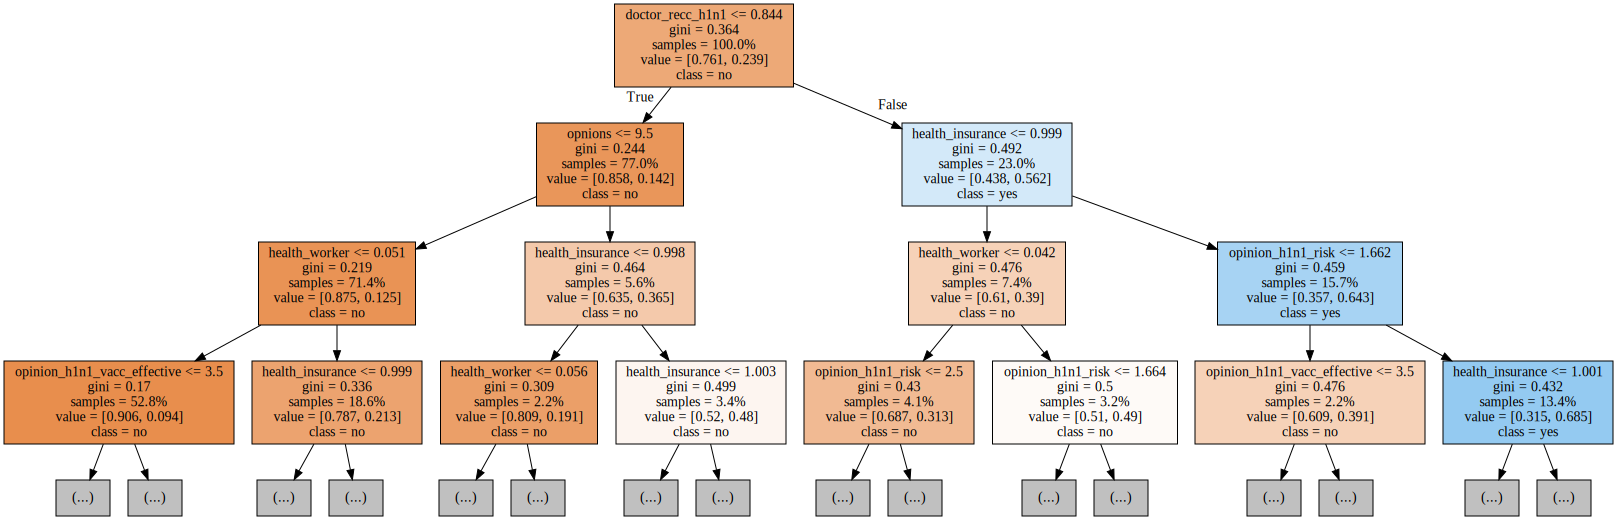

In [ ]:
import graphviz
from sklearn.tree import export_graphviz               #decision tree visualization

model_dt = pipe.named_steps['decisiontreeclassifier']
enc = pipe.named_steps['onehotencoder']
encoded_columns = enc.transform(X_valid).columns

dot_data = export_graphviz(model_dt
                          , max_depth=3
                          , feature_names=encoded_columns
                          , class_names=['no', 'yes']
                          , filled=True
                          , proportion=True)


display(graphviz.Source(dot_data))

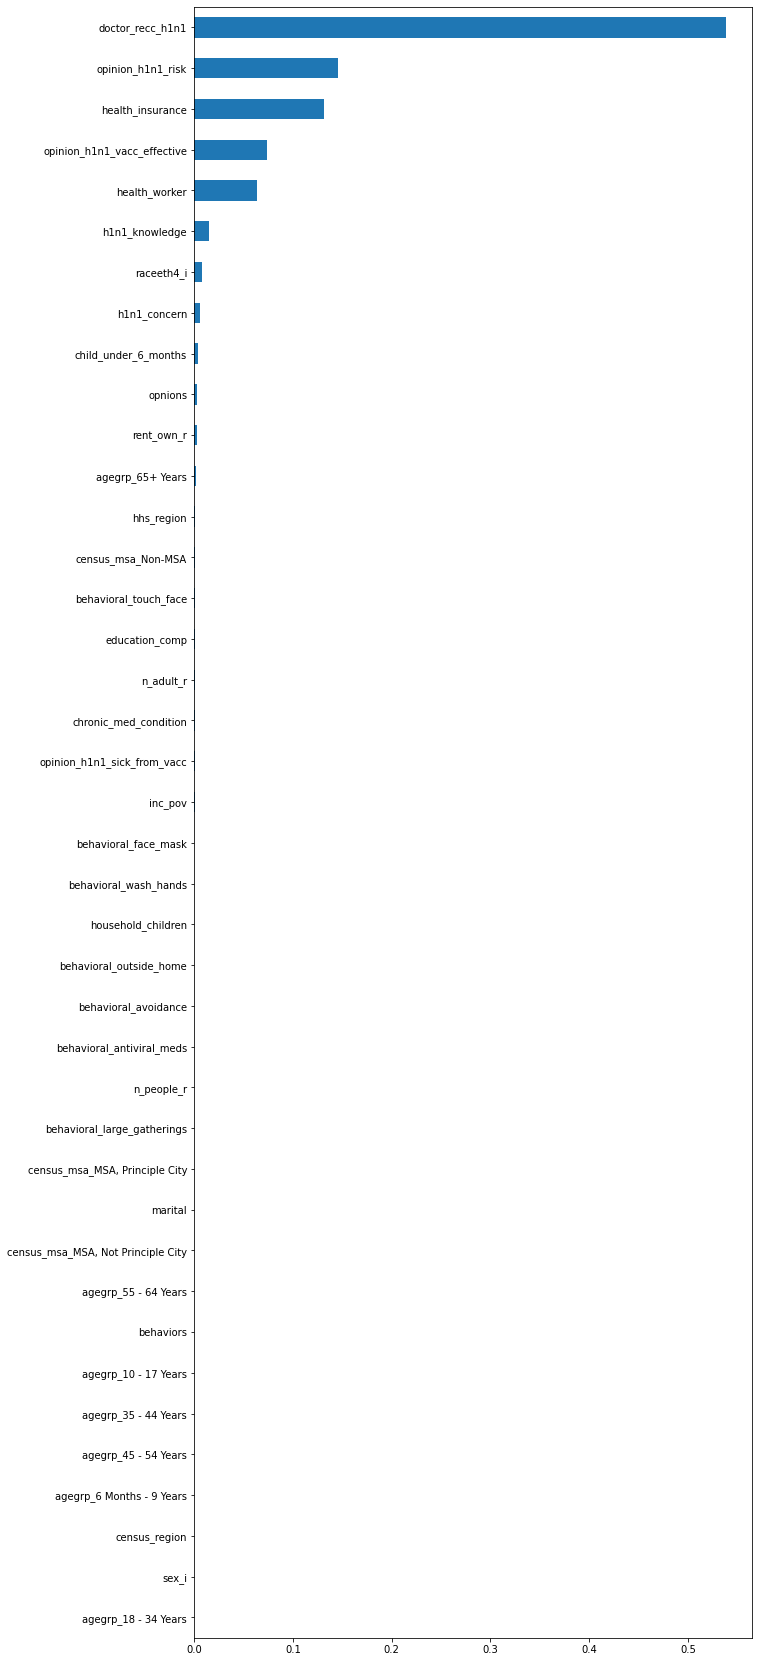

In [ ]:
import matplotlib.pyplot as plt   #특성 중요도

model_dt = pipe.named_steps['decisiontreeclassifier']
enc = pipe.named_steps['onehotencoder']
encoded_columns = enc.transform(X_valid).columns
importances = pd.Series(model_dt.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh();

------------------------------------------------------------------------
Classification Report: Baseline Logistic Regression with Default Params
------------------------------------------------------------------------
              precision    recall  f1-score   support

     No Vacc       0.84      0.93      0.89      8020
     Vaccine       0.68      0.44      0.54      2519

    accuracy                           0.82     10539
   macro avg       0.76      0.69      0.71     10539
weighted avg       0.80      0.82      0.80     10539

------------------------------------------------------------------------
------------------------------------------------------------------------




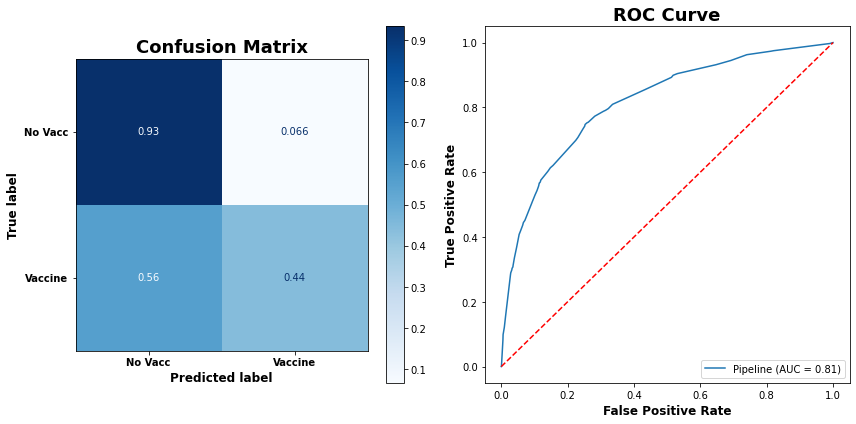

In [ ]:
make_classifier(pipe, X_valid, y_valid, model_descr='Baseline Logistic Regression with Default Params');

### 3)
 

In [ ]:
predict = pipe.predict(X_test)
predict

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
submission = pd.read_csv('/content/submission.csv')
submission['vacc_h1n1_f'] = predict

In [ ]:
submission

,Id,vacc_h1n1_f
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
28099,28099,0
28100,28100,0
28101,28101,0
28102,28102,0


In [ ]:
submission.to_csv('submission.csv', index=False)

## 🔥


### 4)

In [ ]:
pip install scikit-learn==0.21rc2

In [ ]:
from sklearn.impute import IterativeImputer


pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    IterativeImputer(), 
    DecisionTreeClassifier(max_depth=6, random_state=1))

pipe.fit(X_train, y_train)
print('훈련 정확도', pipe.score(X_train, y_train))
print('검증 정확도', pipe.score(X_valid, y_valid)) #simple을 사용할때 와 큰 차이를 보이진 않음.

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도 0.8273920607306658
검증 정확도 0.8143087579466742


In [ ]:
ipe_lr = pipe.named_steps['decisiontreeclassifier']

importances = pd.Series(ipe_lr.feature_importances_, encoded_columns) #Feature Importances
importances.sort_values(ascending=False)

doctor_recc_h1n1                      0.558035
health_insurance                      0.157525
opinion_h1n1_risk                     0.084062
health_worker                         0.065260
opnions                               0.060311
opinion_h1n1_vacc_effective           0.047437
child_under_6_months                  0.009907
rent_own_r                            0.002215
opinion_h1n1_sick_from_vacc           0.002164
raceeth4_i                            0.002016
n_people_r                            0.002006
behavioral_wash_hands                 0.001870
education_comp                        0.001831
h1n1_knowledge                        0.001716
sex_i                                 0.001187
h1n1_concern                          0.001138
agegrp_55 - 64 Years                  0.000946
hhs_region                            0.000376
agegrp_6 Months - 9 Years             0.000000
chronic_med_condition                 0.000000
behavioral_antiviral_meds             0.000000
behavioral_av

특성 중요도를 나열해보니 doctor_recc_h1n1 (의사 소견), health_insurance (보험) 이 중요한 부분이라는걸 알수 있었다.

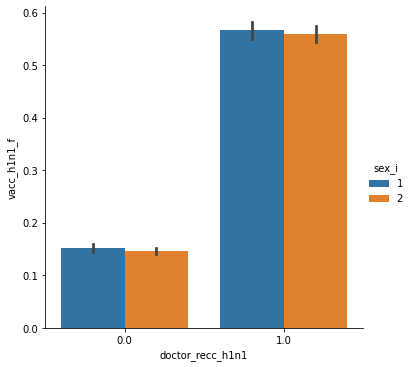

In [ ]:
sns.catplot(data = train, x = 'doctor_recc_h1n1', y = 'vacc_h1n1_f', hue = 'sex_i', kind = 'bar')

의사 소견을 듣고 따라서 백신 접종하는 경우가 더 많다.

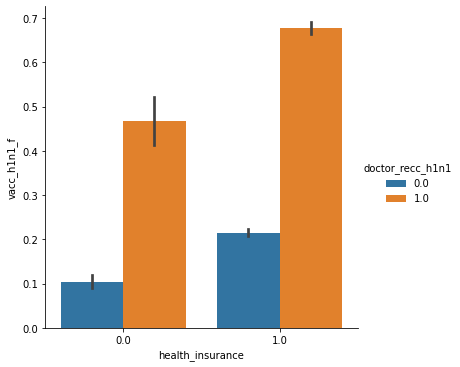

In [ ]:
sns.catplot(x="health_insurance", y="vacc_h1n1_f", hue="doctor_recc_h1n1", kind="bar", data=train);

이어서 보험과 의사소견 특성을 고려해 분석해본 결과

보험가입자는 백신 접종률이 상대적으로 높음.

